In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


In [2]:
N = 1000
dt = 1/255
T = 255 - 125
r = 0.025
t = np.arange(T+1)
w = np.random.normal(0, 1, size=(N, T)) # The brownian motion parameter

## Standard Geometric Brownian Motion

For any asset let the price series be $ S_{t} $.  
The return is

$
r_{t} = ln(\frac{S_{t}}{S_{t-1}})
$

We estimate:

- Mean return:
$
\mu = \frac{1}{T-1} \sum_{t=1}^{T-1} r_{t}
$

- Volatility:
$
\sigma = \sqrt{\frac{1}{T-2} \sum_{t=1}^{T-1} (r_{t} - \mu_i)^2}
$

For each path $i \epsilon N$ and time step $j \epsilon T$:

$
S_{i,j} = S_0 \exp\left( \sum_{k=1}^j \left( \left(r - \tfrac{1}{2}\sigma^2\right)\Delta t \;+\; \sigma \sqrt{\Delta t}\, W_{i,k} \right) \right)
$

Or for path $i \epsilon N$ and time step $j \epsilon (T-1)$:

$
S_{i,j+1} = S_{i,j} \exp((r - \tfrac{1}{2}\sigma^2)\Delta t \;+\; \sigma \sqrt{\Delta t}\, W_{i,k})
$

In [3]:
df = pd.read_csv("NHY_historical_price.csv", sep=";")

S = np.array(df['Close'].astype(float))
S0 = S[-1]
S0

63.92

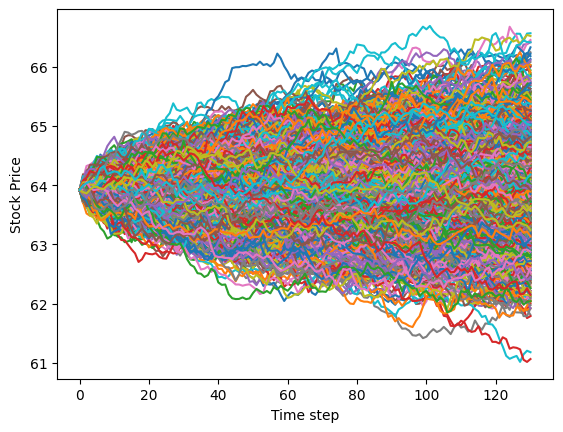

(0.0008479995430211037, 0.01960395087606236)

In [4]:
ln_S = np.log(S)
rt = np.diff(ln_S)

mu = np.mean(rt)
sd = np.std(rt, ddof=2)

S_t = np.zeros((N,T+1))
S_t[:,0] = S0

for i in range(N):
    S_t[i,1:] = S0*np.exp(np.cumsum((mu - 0.5 * (sd**2))*dt + sd*np.sqrt(dt)*w[i,:]))


for i in range(N):
    plt.plot(t, S_t[i])
plt.xlabel("Time step")
plt.ylabel("Stock Price")
plt.show()
(mu, sd)

## Using Ornstein–Uhlenbeck (OU) process for mean reverting stocks

We assume the **log-price process** $X_t = \ln S_t$ follows an **Ornstein–Uhlenbeck (OU) process**:

$ dX_t = \kappa (\mu - X_t)\,dt + \sigma \, dW_t, $

where  

- $\kappa > 0$ is the speed of mean reversion,  
- $\mu$ is the long-run mean of the log-price,  
- $\sigma$ is the volatility,  
- $W_t$ is a standard Wiener process.

Given a time series $S$, define:

$X_t = \log(S_{t})$ for $t = 0, 1, \dots, n-1$  
$X_{t+1} = \log(S_{t+1})$ for $t = 0, 1, \dots, n-1$

Perform an OLS regression:

$X_{t+1} = \alpha + \beta X_t + \varepsilon_t$

where $\varepsilon_t$ are the residuals. Let $\sigma_\varepsilon = \text{std}(\varepsilon_t)$.

Then the parameters are estimated as:

$ \kappa = -\frac{\log(\beta)}{\Delta t} $

$ \mu = \frac{\alpha}{1 - \beta} $

$ \sigma = \sigma_\varepsilon \sqrt{\frac{2 \kappa}{1 - \beta^2}} $


In [23]:
X_t = np.log(np.array(S[:-1]))
X_next = np.log(np.array(S[1:]))

X_design = sm.add_constant(X_t)  # intercept + X_t
model = sm.OLS(X_next, X_design).fit()
alpha, beta = model.params
resid_std = np.std(model.resid, ddof=1)

kappa = -np.log(beta) / dt
mu = alpha / (1 - beta)
sigma = (resid_std) # * np.sqrt(2*kappa / (1 - beta**2)))

print("Estimated parameters:")
print(f"kappa  = {kappa:.4f}")
print(f"mu     = {mu:.4f}")
print(f"sigma  = {sigma:.4f}")

Estimated parameters:
kappa  = 5.7817
mu     = 4.1457
sigma  = 0.0194


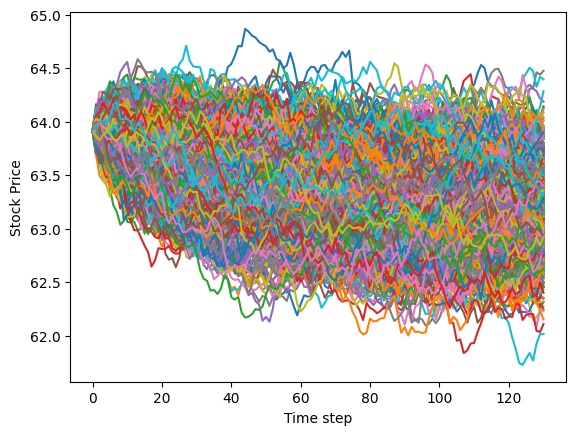

In [24]:
X_t = np.zeros((N, T+1))      # log-price paths
S_t = np.zeros((N, T+1))      # price paths
X_t[:, 0] = np.log(S0)       # initial log-price
S_t[:, 0] = S0

for time_step in range(1, T+1):
    drift = kappa * (mu - X_t[:,time_step - 1]) * dt
    diffusion = sigma * np.sqrt(dt) * w[:,time_step - 1]   # w ~ N(0,1)
    X_t[:,time_step ]  = X_t[:,time_step - 1] + drift + diffusion

    S_t[:, t] = np.exp(X_t[:, t])

for i in range(N):
    plt.plot(t, S_t[i])
plt.xlabel("Time step")
plt.ylabel("Stock Price")
plt.show()

## Using The Merton Jump Diffusion Model for jumping shocks on stock prices


$
dS_{t} = r S_{t} dt + \sigma S_t dW_{t} + (e^J - 1) S_t dN_t 
$

- $dN_t$ is a Poisson jump process with intensity $\lambda$. $ \lambda $ tells how often / likely a jump is to occur at time $t$.

- Jump sizes are normally distributed in log-space:

$
J \sim \mathcal{N}(\mu_{J}, \sigma_{J})
$


Discrete: 

$
X_{t+\Delta t} = X_{t} + (r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t} W_{t} + J_t 
$

$
S_{t + \Delta t} = \exp(X_{t + \Delta t})
$

where:

$J_t \sim \mathcal{N}(\mu_{J}, \sigma_{J}) $ * $ \mathcal{P}(jump\_lambda*dt) $

$ \mathcal{P} $ is weather a jump occurs or not, drawn from a poisson process.  

$jump\_lambda $ is the likelyhood of a jump at time during the period $0, \dots, T$ 

$ X_t = ln(S_t) $

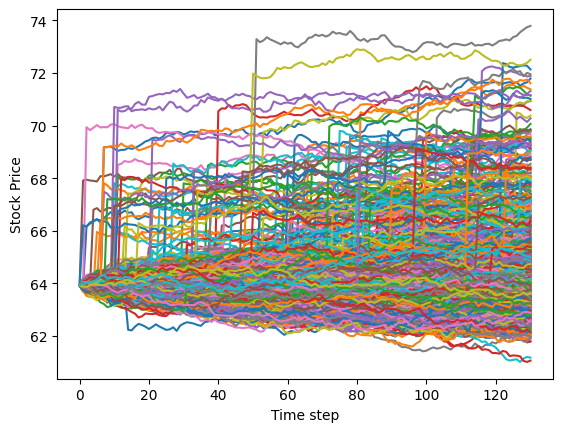

In [25]:
ln_S = np.log(S)
rt = np.diff(ln_S)

mu = np.mean(rt)
sd = np.std(rt, ddof=2)

lambda_jump = 0.35  # expected # of jumps per horizon (125 days ~ 0.5 years)
jump_mean = np.log(1.05)   # 5% up jump in log terms
jump_sd = 0.025

X_t = np.zeros((N, T+1))      # log-price paths
S_t = np.zeros((N, T+1))      # price paths
X_t[:, 0] = np.log(S0)       # initial log-price
S_t[:, 0] = S0

for sim_step in range(N):
    # Number of jumps each step (Poisson)
    N_jumps = np.random.poisson(lambda_jump * dt, size=T)

    # Jump sizes: independent normal draws per step
    J_t = np.random.normal(jump_mean, jump_sd, size=T) * N_jumps

    for time_step in range(1, T+1):
        # diffusion part
        drift = (mu - 0.5 * sd**2) * dt
        diffusion = sd * np.sqrt(dt) * w[sim_step, time_step-1]

        # recursive update of log-price
        X_t[sim_step, time_step] = (
            X_t[sim_step, time_step-1] + drift + diffusion + J_t[time_step-1]
        )
        S_t[sim_step, time_step] = np.exp(X_t[sim_step, time_step])


for i in range(N):
    plt.plot(t, S_t[i])
plt.xlabel("Time step")
plt.ylabel("Stock Price")
plt.show()

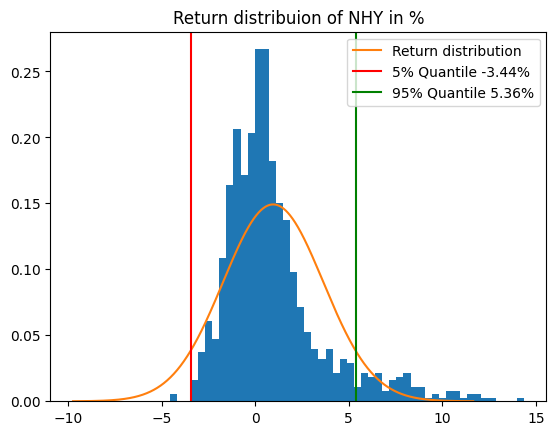

(0.9576497991412308, 2.6743033700066308)

In [26]:
rp = 100*np.log(S_t[:,T] / S0)

rp_mu = np.mean(rp)
rp_sd = np.std(rp, ddof=1)

q05 = round(stats.norm.ppf(0.05, loc=rp_mu, scale=rp_sd), 2)
q95 = round(stats.norm.ppf(0.95, loc=rp_mu, scale=rp_sd), 2)

xs = np.arange(start = rp_mu - 4*rp_sd, stop = rp_mu + 4*rp_sd, step = (rp_mu + 8*rp_sd) / 1000)
ys = stats.norm.pdf(xs, rp_mu, rp_sd)

plt.hist(rp, bins=50, density=True)
plt.title("Return distribuion of NHY in %")
plt.plot(xs, ys, label="Return distribution")
plt.axvline(q05, label=f'5% Quantile {q05}%', color='red')
plt.axvline(q95, label=f'95% Quantile {q95}%', color='green')
plt.legend()
plt.show()
(rp_mu, rp_sd)

## GBM med korrelasjon

Modellerer aksje $A_t$ og $B_t$ de er korrelert med korrelasjon $\rho \epsilon [-1,1]$

Begge beveger seg med Geometrisk Brownsk Bevegelse med driftskoeffesient risikofri rente $r$.

$dA_t = r A_t dt + \sigma_A A_t dW_{t}^A $

$dB_t = r B_t dt + \sigma_B B_t dW_{t}^B $

Vi har korrelasjonsmatrise:

$ K = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix} $

Benytter Cholesky dekomponering til å finne nedre triangel $L$ av $K$ slik at 

$K = L L^\top$

For en 2 $\times$ 2 matrise er $L$: 

$
L = \begin{bmatrix} 
1 & 0 \\ 
\rho & \sqrt{1-\rho^2} 
\end{bmatrix}
$

De tilfeldige sjokkene for en hver tid $t$ for de to aksjene A og B er gitt ved 

$
\mathbf{Z_{t}} = \begin{bmatrix} Z_{t}^A \\ Z_{t}^B \end{bmatrix}, 
\quad Z_{t} \sim \mathcal{N}(0,1) \text{ i.i.d.}
$

De korrelerte sjokkene blir da:

$\mathbf{W_t} = L \mathbf{Z_t}$

$ \mathbf{W_t} = \begin{bmatrix} W_{t}^A \\ W_{t}^B \end{bmatrix} = \begin{bmatrix} Z_{t}^A \\ Z_{t}^B \end{bmatrix}  \begin{bmatrix} 1 & 0 \\ \rho & \sqrt{1-\rho^2} \end{bmatrix} = \begin{bmatrix} Z_{t}^A \\ Z_{t}^A + \sqrt{1-\rho^2} \, Z_{t}^B\end{bmatrix} $

Og nå vil utviklingene til kursimuleringene være hhv korrelert gitt ved:

$ A_t = A_0 e^{(r - \frac{1}{2} \sigma_A^2)t + \sigma_A W_{t}^A} $

$ A_t = B_0 e^{(r - \frac{1}{2} \sigma_B^2)t + \sigma_B W_{t}^B} $

In [28]:
Mdf = pd.read_csv('../Aksjeanalyse/MOWI/Mowi Stock Price History.csv')
M = np.array(Mdf['Price'].astype(float))

M0 = M[-1]
M0

164.7

In [29]:
stock_prices = pd.DataFrame({'MOWI': M[-len(S):], 'NHY': S})

K = stock_prices.corr()
K

,MOWI,NHY
MOWI,1.000000,-0.597643
NHY,-0.597643,1.000000


In [30]:
L = np.linalg.cholesky(K)
L

array([[ 1.        ,  0.        ],
       [-0.59764348,  0.80176198]])

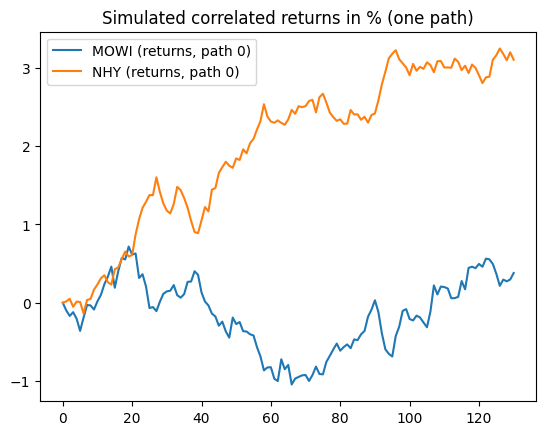

In [ ]:
mowi_r = np.diff(np.log(stock_prices['MOWI']))
nhy_r = np.diff(np.log(stock_prices['NHY']))

mowi_sd = np.std(mowi_r)
nhy_sd = np.std(nhy_r)

S_mowi = np.zeros((N, T+1))
S_nhy  = np.zeros((N, T+1))
S_nhy[:, 0] = S0
S_mowi[:, 0] = M0

for i in range(N):
    # independent normals for this path
    Z = np.random.normal(size=(T, 2))
    
    # correlate via Cholesky
    w = np.inner(Z, L.T)   # shape (T,2) one for each stock
    
    # daily increments with drift + diffusion
    incr_mowi = (r - 0.5 * mowi_sd**2) * dt + mowi_sd * np.sqrt(dt) * w[:,0]
    incr_nhy  = (r - 0.5 * nhy_sd**2)  * dt + nhy_sd  * np.sqrt(dt) * w[:,1]
    
    # cumulative log returns
    S_mowi[i,1:] = M0*np.exp(np.cumsum(incr_mowi))
    S_nhy[i,1:]  = S0*np.exp(np.cumsum(incr_nhy))

# Simulating path no. 42
plt.plot(100*(S_mowi[42,:]/M0 - 1), label="MOWI (returns, path 0)")
plt.plot(100*(S_nhy[42,:]/S0 - 1), label="NHY (returns, path 0)")
plt.title("Simulated correlated returns in % (one path)")
plt.legend()
plt.show()